In [1]:
import pickle
import os
import numpy as np

from utils.funs import scores

from transformers import AutoModelForCausalLM

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getscoresTinyGPT(d,l,h,dh,model):
    """
    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros(l)
    NList = np.zeros(l)
    
    # retrieve all block instances (each layer in the GPT architecture)
    layers = model.transformer.h

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attn.attention

        # access parameters of Conv1D
        Wq = self_attention.q_proj._parameters["weight"].T.detach().numpy()
        Wk = self_attention.k_proj._parameters["weight"].T.detach().numpy()
            
        # calculate the association matrix M
        M = Wq @ Wk.T
        # compute symmetry and skew-symmetry scores
        S, N = scores(M)
        SList[i], NList[i] = S, N

    return  SList, NList

In [3]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../_data/fig_scores/TinyGPT-query-key-full.pkl'):
    with open('../_data/fig_scores/TinyGPT-query-key-full.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
dh = 64

'TinyGPT 1m (l = 8, d = 64, h = 1 ; 1M parameters)'
l = 8
d = 64
h = d // dh
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1M")
S, N = getscoresTinyGPT(d,l,h,dh,model)
models['TinyGPT-1m'] = [l,d,h,dh,S,N]

'TinyGPT 3m (l = 8, d = 64, h = 2 ; 3M parameters)'
l = 8
d = 128
h = d // dh
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-3M")
S, N = getscoresTinyGPT(d,l,h,dh,model)
models['TinyGPT-3m'] = [l,d,h,dh,S,N]

'TinyGPT 8m (l = 8, d = 64, h = 4 ; 8M parameters)'
l = 8
d = 256
h = d // dh
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-8M")
S, N = getscoresTinyGPT(d,l,h,dh,model)
models['TinyGPT-8m'] = [l,d,h,dh,S,N]

'TinyGPT 1layer 21M (l = 1, d = 1024 h = 16 ; 21M parameters)'
l = 1
d = 1024
h = d // dh
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1Layer-21M")
S, N = getscoresTinyGPT(d,l,h,dh,model)
models['TinyGPT-21m'] = [l,d,h,dh,S,N]

'TinyGPT 28M (l = 8, d = 512 h = 8 ; 28M parameters)'
l = 8
d = 512
h = d // dh
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-28M")
S, N = getscoresTinyGPT(d,l,h,dh,model)
models['TinyGPT-28m'] = [l,d,h,dh,S,N]

'save'
with open('../_data/fig_scores/TinyGPT-query-key-full.pkl', 'wb') as file:
    pickle.dump(models, file)

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(0.0, 1.0)

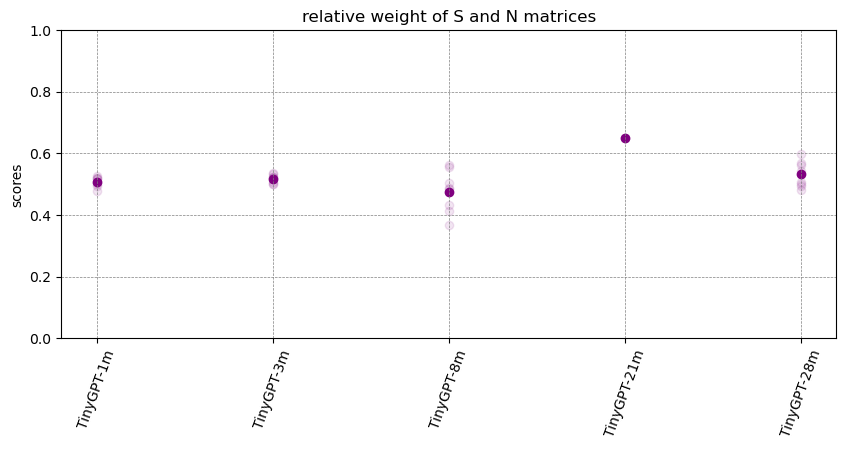

In [5]:
import matplotlib.pyplot as plt

with open('../_data/fig_scores/TinyGPT-query-key-full.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)